In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

from fastai.vision.all import *
from PIL import Image
import numpy as np
import random

# seed function for reproducibility
def random_seed(seed_value):
    np.random.seed(seed_value) 
    torch.manual_seed(seed_value) 
    random.seed(seed_value) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False
        
random_seed(113) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Load the Dataset

In [47]:
train_dir = "train/"
test_dir = "test/"

In [48]:
# High level API
trainloader = ImageDataLoaders.from_folder(train_dir, valid_pct=0.2, seed=11,
                                          item_tfms=Resize(224), num_workers=0, bs=12)

## TRY THIS create train loader using mid level API DataBlock!
# item_tfms = RandomResizedCrop(224, min_scale=0.75, ratio=(1.,1.))
# splitter = RandomSplitter(valid_pct=.3, seed=113)

# trainblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
#                        get_items=get_image_files,
#                        get_y=parent_label,
#                        item_tfms=item_tfms,
#                        splitter=splitter
#                       )
# trainloader = trainblock.dataloaders(train_dir, num_workers=0, bs=12)

# Explore the Data

In [50]:
print("original image shape :",array(Image.open(trainloader.train.items[0])).shape)
print("loaded image shape :",trainloader.one_batch()[0][0].shape)
print("train batch size :",len(trainloader.train), "- with around", trainloader.bs, "images/batch")
print("train size :",len(trainloader.train.items))
print("valid batch size :",len(trainloader.valid), "- with around", trainloader.bs, "images/batch")
print("valid size :",len(trainloader.valid.items))
print("classes:", trainloader.vocab.o2i)

original image shape : (256, 256, 3)
loaded image shape : torch.Size([3, 224, 224])
train batch size : 62 - with around 12 images/batch
train size : 752
valid batch size : 16 - with around 12 images/batch
valid size : 188
classes: {'JUICE': 0, 'MILK': 1, 'SODA': 2, 'VINEGAR': 3, 'WATER': 4}


<AxesSubplot:>

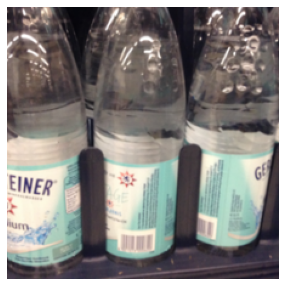

In [51]:
trainloader.one_batch()[0][0].show()

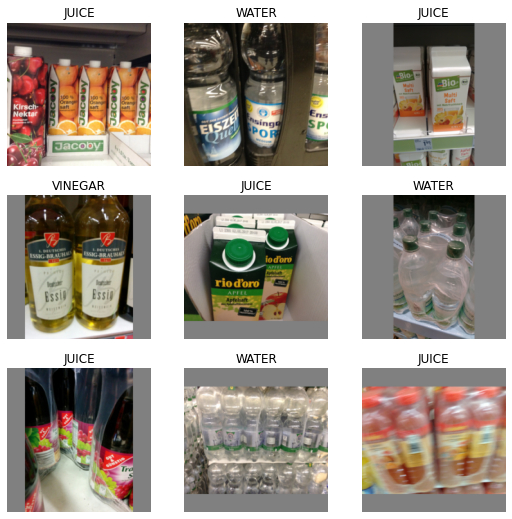

In [52]:
trainloader.show_batch()

# Training Process

In [53]:
learn = cnn_learner(trainloader, resnet18, metrics=error_rate) # high-level learner, using pre-trained model
learn.fine_tune(1) # 1 epoch freezed, then 1 epoch fine_tune

epoch,train_loss,valid_loss,error_rate,time
0,1.447003,0.721440,0.218085,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.624352,0.624596,0.175532,00:25


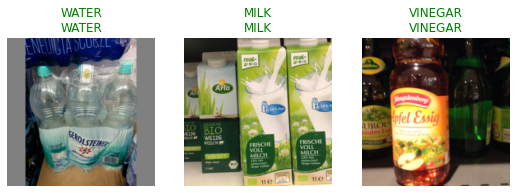

In [54]:
learn.show_results(max_n=3)

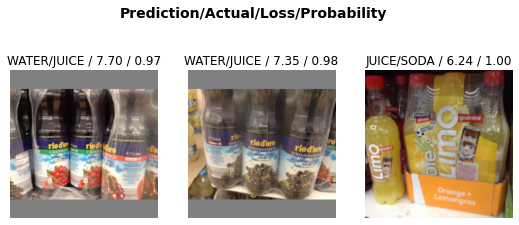

In [55]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(3, figsize=(9,4))

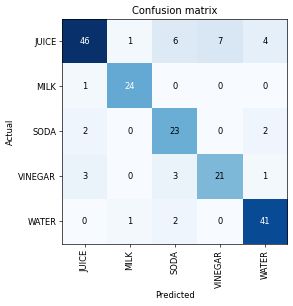

In [56]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [57]:
learn.export("C:/Users/H P/Documents/Code/groceries_classification/model.pkl") # inference-only model
learn.save("learn") # the model that able to re-train and show anything

Path('train/models/learn.pth')

# Sanity Check

In [58]:
model_infer = load_learner('model.pkl')

In [59]:
model_infer.predict(trainloader.items[0])

('VINEGAR',
 tensor(3),
 tensor([4.7062e-04, 1.1889e-05, 3.0944e-06, 9.9951e-01, 3.7417e-06]))

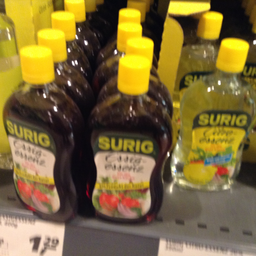

In [60]:
Image.open(trainloader.items[0])

# Continue the training

In [50]:
model = cnn_learner(trainloader, resnet18, metrics=error_rate) # define the model
model.load("learn") # get saved checkpoint, format: "model/" + PATH + ".pth"

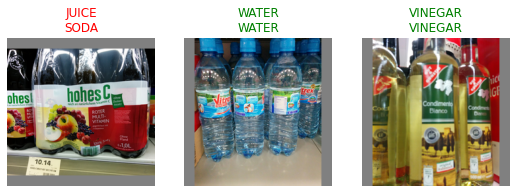

In [51]:
model.show_results(max_n=3)

In [52]:
model.unfreeze() # try to unfreeze all layers
model.fit(1, lr=0.00001) # use small learning rate to fine tune

epoch,train_loss,valid_loss,error_rate,time
0,0.467919,0.614837,0.195035,00:23


# Custom Architecture

Try to use custom architecture in fastai

please also remember the formula to calculate the size of feature after convolution (defined in `self.conv_size()`):

$$\frac{(FEATURE - KERNEL + 2*PADDING)}{STRIDE} +1$$

In [9]:
########################
# 1. Neural Net Model using Class (the most common)
#######################

class Net(nn.Module):
    
    def __init__(self, ks=4, ps=3, fm1=16, fm2=32, n=256):
    
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, fm1, kernel_size=ks, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=ps, stride=2, padding=0)
        self.conv2 = nn.Conv2d(fm1, fm2, kernel_size=ks, stride=1, padding=0)
        
        # calculate CNN's output size
        res = self.conv_size(self.conv_size(self.conv_size(self.conv_size(img_size, ks), ps, s=2), ks), ps, s=2)**2*fm2
        
        self.fc1 = nn.Linear(res, n)
        self.fc2 = nn.Linear(n, n_labels)
        self.do = nn.Dropout()

    def conv_size(self, inp, k, p=0, s=1):
        return (inp-k+2*p)//s+1
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(x.shape[0], -1)
        x = self.do(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
    
img_size = 224
n_labels = 5
model = Net().to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=89888, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
  (do): Dropout(p=0.5, inplace=False)
)

In [9]:
learn = Learner(trainloader, model, metrics=error_rate) # use mid-level API
learn.fit(10) # train 10 epochs

epoch,train_loss,valid_loss,error_rate,time
0,1.574297,1.254154,0.510638,00:21
1,1.300488,1.090816,0.464539,00:20
2,1.155449,1.007579,0.400709,00:21
3,1.056595,0.996204,0.421986,00:20
4,0.935936,0.969233,0.361702,00:21
5,0.874854,0.943824,0.351064,00:21
6,0.819252,1.018769,0.375887,00:21
7,0.774237,0.980412,0.372340,00:21
8,0.699043,1.061193,0.386525,00:22
9,0.674520,0.991410,0.329787,00:21


# Test with test set

In [61]:
model_infer = load_learner('model.pkl')

In [69]:
testloader = model_infer.dls.test_dl(get_image_files("test"), 
                                     with_labels=True,
                                     num_workers=0)

In [70]:
preds, targs = model_infer.get_preds(dl=testloader)

In [71]:
accuracy(preds, targs)

TensorBase(0.7917)